# Perch Multi Seed Validation
#### 5 Random (but reproducible) seeds are selected for 5 different runs of train/test
#### Models have been optimised and verified on validation sets thoroughly, running a final train/test evaluation here
#### The setup:

- 4 fold StratifiedGroupKFold for stratification and ensuring each cat_id group only appears in one set at a time
- Final scores averaged over the 4 folds
- For each seed run we will explore the cat_id predictions through majority voting
- For each run we will explore the potential impact of gender
- Includes visualisations & analysis

The dataset is highly unbalanced.

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import random
from datetime import datetime
from collections import Counter

# Sklearn imports
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GroupKFold, StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance

# Imbalanced-learn import
from imblearn.over_sampling import SMOTE

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax, AdamW
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.utils import to_categorical
from keras.regularizers import l1, l2, L1L2

# Optuna import
import optuna

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import statistical tests
from scipy.stats import levene

from IPython.display import display
import time

In [2]:
# Track running time (including analysis)
start_time = time.time()

In [3]:
# Set an initial seed for reproducibility
np.random.seed(42)  

# Generate a list of 5 random seeds
random_seeds = np.random.randint(0, 10000, size=5)
print("Random Seeds:", random_seeds)

Random Seeds: [7270  860 5390 5191 5734]


#### TOTAL RESULTS ACROSS SEED INITIATION

In [4]:
# Lists to collect statistics across all CVs
all_losses, all_accuracies, all_precisions, all_recalls, all_f1 = [], [], [], [], []
average_fold_losses, average_fold_accuracies, average_fold_precisions, average_fold_recalls, average_fold_f1 = [], [], [], [], []
all_majority_vote_accuracies, all_majority_vote_details, all_class_stats, all_gender_stats  = [], [], [], []

# training accuracies
all_best_training_acc = []
total_training_acc = []

## Define Functions

In [5]:
def check_initial_group_split(groups_train, groups_test):
    """
    Check if any group is present in both the train and test sets.

    Parameters:
    - groups_train: Array of group identifiers for the train set
    - groups_test: Array of group identifiers for the test set

    Returns:
    - Prints out any groups found in both sets and the count of such groups
    """
    train_groups = set(groups_train)
    test_groups = set(groups_test)
    common_groups = train_groups.intersection(test_groups)

    if common_groups:
        print(f"Warning: Found {len(common_groups)} common groups in both train/validation and test sets: {common_groups}")
    else:
        print("No common groups found between train and test sets.")


In [6]:
# Function to perform the swaps based on cat_id, ensuring swaps within the same age_group
def swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids):
    for cat_id in specific_cat_ids:
        # Check if the specific cat_id is not in the training set
        if cat_id not in dataframe.iloc[train_val_idx]['cat_id'].values:
            # Get the age_group of this cat_id
            age_group = dataframe[dataframe['cat_id'] == cat_id]['age_group'].iloc[0]
                
            # Find a different cat_id within the same age_group in the train set that is not in the test set
            other_cat_ids_in_age_group = dataframe[(dataframe['age_group'] == age_group) & 
                                                   (dataframe['cat_id'] != cat_id) &
                                                   (~dataframe['cat_id'].isin(dataframe.iloc[test_idx]['cat_id']))]['cat_id'].unique()
            
            # Choose one other cat_id for swapping
            if len(other_cat_ids_in_age_group) > 0:
                other_cat_id = np.random.choice(other_cat_ids_in_age_group)

                # Find all instances of the other_cat_id in the train set
                other_cat_id_train_val_indices = train_val_idx[dataframe.iloc[train_val_idx]['cat_id'] == other_cat_id]
                
                # Find all instances of the specific cat_id in the test set
                cat_id_test_indices = test_idx[dataframe.iloc[test_idx]['cat_id'] == cat_id]
                
                # Swap the indices
                train_val_idx = np.setdiff1d(train_val_idx, other_cat_id_train_val_indices, assume_unique=True)
                test_idx = np.setdiff1d(test_idx, cat_id_test_indices, assume_unique=True)

                train_val_idx = np.concatenate((train_val_idx, cat_id_test_indices))
                test_idx = np.concatenate((test_idx, other_cat_id_train_val_indices))
            else:
                print(f"No alternative cat_id found in the same age_group as {cat_id} for swapping.")
                
    return train_val_idx, test_idx

In [7]:
# Function to identify differences in groups
def find_group_differences(original, new):
    # Convert numpy arrays to sets for easy difference computation
    original_set = set(original)
    new_set = set(new)
    # Find differences
    moved_to_new = new_set - original_set
    moved_to_original = original_set - new_set
    return moved_to_new, moved_to_original

In [8]:
# create custom logger function for local logs & stored in a .txt
def logger(message, file=None):
    print(message)
    if file is not None:
        with open(file, "a") as log_file:
            log_file.write(message + "\n")

log_file_path = "multi-seed-val-D13.txt" 

In [9]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid", palette="deep")

# Define a custom color palette
colors = ["#6aabd1", "#b6e2d3", "#dac292"] 
sns.set_palette(sns.color_palette(colors))

# Function to create bar plots with enhanced style
def styled_barplot(data, x, y, title, xlabel, ylabel):
    plt.figure(figsize=(8, 4))
    bar_plot = sns.barplot(x=x, y=y, data=data, errorbar=None, width=0.5)  
    plt.title(title, fontsize=16, fontweight='bold', color="#333333")
    plt.xlabel(xlabel, fontsize=14, fontweight='bold', color="#333333")
    plt.ylabel(ylabel, fontsize=14, fontweight='bold', color="#333333")
    plt.xticks(fontsize=12, color="#333333")
    plt.yticks(fontsize=12, color="#333333")
    plt.ylim(0, 100) 

    # Adding value labels on top of each bar
    for p in bar_plot.patches:
        height = p.get_height()
        # Annotate the height value on the bar
        bar_plot.annotate(f'{height:.1f}', 
                          (p.get_x() + p.get_width() / 2., height), 
                          ha='center', va='center', 
                          xytext=(0, 9), 
                          textcoords='offset points', fontsize=12, color="#333333")

    plt.show()

In [10]:
def plot_all_metrics(losses, accuracies, precisions, recalls, f1, metrics_across, x_axis_label):
    fig, ax = plt.subplots(figsize=(12, 8))
    seeds = range(1, len(losses) + 1)

    ax.plot(seeds, losses, marker='o', color='blue', label='Loss')
    ax.plot(seeds, accuracies, marker='o', color='green', label='Accuracy')
    ax.plot(seeds, precisions, marker='o', color='red', label='Precision')
    ax.plot(seeds, recalls, marker='o', color='purple', label='Recall')
    ax.plot(seeds, f1, marker='o', color='orange', label='F1 Score')

    ax.set_title(f'Metrics Across {metrics_across}')
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel('Metric Value')
    ax.set_xticks(seeds)
    ax.legend()
    ax.grid(True)

    return fig

In [11]:
# store epoch accs
class AccuracyHistory(Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('accuracy'))

# RANDOM SEED 1

## Prepare Data

In [12]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[0]))
np.random.seed(int(random_seeds[0]))
tf.random.set_seed(int(random_seeds[0]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/perch-2/scripts/perch_embeddings_april_10.csv')
augmented_df = pd.read_csv('/Users/astrid/PycharmProjects/perch-2/scripts/perch_embeddings_augmented_d3.csv')

dataframe.drop('mean_freq', axis=1, inplace=True)

augmented_df.drop('mean_freq', axis=1, inplace=True)
augmented_df.drop('gender', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)
augmented_df['age_group'] = augmented_df['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())
print(augmented_df['age_group'].value_counts())

adult     509
senior    149
kitten    135
Name: age_group, dtype: int64
senior    900
kitten    820
adult     758
Name: age_group, dtype: int64


In [13]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [14]:
tf.keras.backend.clear_session()

## Run Setup

In [15]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[0]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ######################
    # ADD AUGMENTED DATA #
    ######################

    # Filter out augmented data derived from groups in the training set
    augmented_df_filtered = augmented_df[augmented_df['cat_id'].isin(groups_train_val)]
    
    # Convert augmented_df_filtered to numpy array (excluding target and other columns)
    augmented_array = augmented_df_filtered.drop(columns=['target', 'cat_id', 'age_group']).values
    
    # Concatenate the filtered augmented data with X_train_val
    X_train_val = np.concatenate([X_train_val, augmented_array])

    # Extract target labels from the filtered augmented DataFrame
    y_augmented = augmented_df_filtered['age_group'].values
    
    # Encode the labels using the same LabelEncoder instance
    y_augmented_encoded = label_encoder.transform(y_augmented)
    
    # Concatenate the encoded augmented labels with y_train_val
    y_train_val = np.concatenate([y_train_val, y_augmented_encoded])

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.00510251984616472)
    }
    
    # Model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.2011047009431978))  
    model_full.add(Dense(256, activation='relu',)) 
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.14956886311951184))  
    model_full.add(Dense(256, activation='relu'))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.42291461228250665))  
    model_full.add(Dense(3, activation='softmax'))  
    
    # Use the optimizer from the parameters
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=64,
                                  verbose=1, callbacks=[early_stopping, accuracy_history])
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1
Train Set Group Distribution:
046A    45
103A    33
002B    30
047A    22
020A    20
        ..
110A     1
064A     1
100A     1
090A     1
024A     1
Name: cat_id, Length: 85, dtype: int64
Testing Set Group Distribution:
000A    39
000B    19
019A    17
097A    15
051A    12
063A    11
028A    11
059A    10
040A    10
022A     9
005A     9
013B     8
095A     7
036A     7
039A     6
003A     4
018A     2
087A     2
069A     2
076A     1
091A     1
043A     1
049A     1
041A     1
048A     1
019B     1
026B     1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
M    249
X    203
F    133
Name: gender, dtype: int64
Testing Set Gender Distribution BEFORE SWAP:
F    98
X    73
M    37
Name: gender, dtype: int64
Unique Cat IDs per Age Group in Training/Validation Set:
age_group
adult     [006A, 033A, 015A, 001A, 103A, 071A, 097B, 074...
kitten    [044A, 014B, 111A, 046A, 047A, 042A, 109A, 050...
senior    [093A, 057A, 106A, 104A, 055A, 113A, 116A, 051..

Epoch 1/1500
39/39 [==============================] - 1s 5ms/step - loss: 0.4627 - accuracy: 0.8388
Epoch 2/1500
39/39 [==============================] - 0s 6ms/step - loss: 0.0916 - accuracy: 0.9682
Epoch 3/1500
39/39 [==============================] - 0s 7ms/step - loss: 0.0500 - accuracy: 0.9824
Epoch 4/1500
39/39 [==============================] - 0s 7ms/step - loss: 0.0271 - accuracy: 0.9939
Epoch 5/1500
39/39 [==============================] - 0s 7ms/step - loss: 0.0209 - accuracy: 0.9935
Epoch 6/1500
39/39 [==============================] - 0s 7ms/step - loss: 0.0181 - accuracy: 0.9943
Epoch 7/1500
39/39 [==============================] - 0s 6ms/step - loss: 0.0144 - accuracy: 0.9963
Epoch 8/1500
39/39 [==============================] - 0s 8ms/step - loss: 0.0086 - accuracy: 0.9984
Epoch 9/1500
39/39 [==============================] - 0s 8ms/step - loss: 0.0097 - accuracy: 0.9967
Epoch 10/1500
39/39 [==============================] - 0s 8ms/step - loss: 0.0057 - accuracy: 0.9984

Epoch 1/1500
41/41 [==============================] - 1s 6ms/step - loss: 0.4527 - accuracy: 0.8394
Epoch 2/1500
41/41 [==============================] - 0s 7ms/step - loss: 0.1022 - accuracy: 0.9637
Epoch 3/1500
41/41 [==============================] - 0s 7ms/step - loss: 0.0502 - accuracy: 0.9815
Epoch 4/1500
41/41 [==============================] - 0s 7ms/step - loss: 0.0379 - accuracy: 0.9888
Epoch 5/1500
41/41 [==============================] - 0s 9ms/step - loss: 0.0262 - accuracy: 0.9931
Epoch 6/1500
41/41 [==============================] - 0s 10ms/step - loss: 0.0138 - accuracy: 0.9954
Epoch 7/1500
41/41 [==============================] - 0s 10ms/step - loss: 0.0147 - accuracy: 0.9965
Epoch 8/1500
41/41 [==============================] - 0s 10ms/step - loss: 0.0083 - accuracy: 0.9981
Epoch 9/1500
41/41 [==============================] - 0s 10ms/step - loss: 0.0093 - accuracy: 0.9973
Epoch 10/1500
41/41 [==============================] - 1s 13ms/step - loss: 0.0050 - accuracy: 0

Epoch 1/1500
40/40 [==============================] - 1s 5ms/step - loss: 0.4253 - accuracy: 0.8531
Epoch 2/1500
40/40 [==============================] - 0s 6ms/step - loss: 0.0901 - accuracy: 0.9738
Epoch 3/1500
40/40 [==============================] - 0s 7ms/step - loss: 0.0390 - accuracy: 0.9897
Epoch 4/1500
40/40 [==============================] - 0s 7ms/step - loss: 0.0278 - accuracy: 0.9929
Epoch 5/1500
40/40 [==============================] - 0s 8ms/step - loss: 0.0183 - accuracy: 0.9952
Epoch 6/1500
40/40 [==============================] - 0s 8ms/step - loss: 0.0208 - accuracy: 0.9936
Epoch 7/1500
40/40 [==============================] - 0s 8ms/step - loss: 0.0116 - accuracy: 0.9972
Epoch 8/1500
40/40 [==============================] - 0s 7ms/step - loss: 0.0084 - accuracy: 0.9984
Epoch 9/1500
40/40 [==============================] - 0s 7ms/step - loss: 0.0098 - accuracy: 0.9964
Epoch 10/1500
40/40 [==============================] - 0s 9ms/step - loss: 0.0064 - accuracy: 0.9980

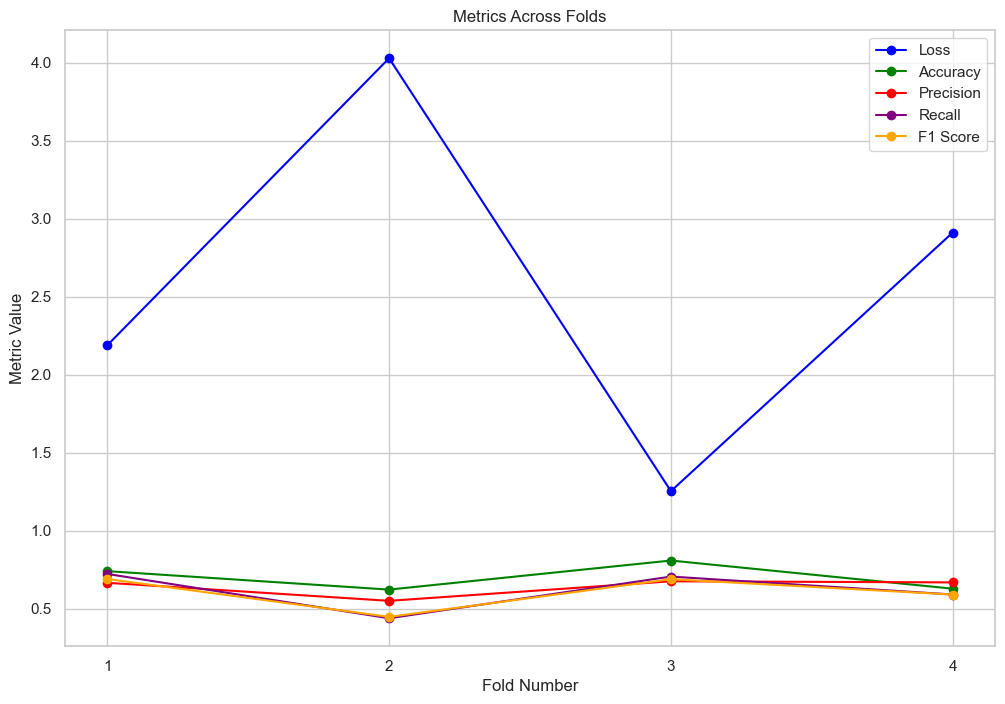

In [16]:
seed_1_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_1_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_1_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [17]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 714, Predictions: 714, Actuals: 714, Gender: 714


In [18]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [19]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.75 (82/110)


In [20]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [21]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, senior, adult, adult, adult, adult, ad...",adult,adult,True
80,074A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
78,072A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
77,071A,"[adult, adult, adult, adult, adult, senior, ad...",adult,adult,True
76,070A,"[adult, adult, adult, adult, adult]",adult,adult,True
75,069A,"[adult, adult]",adult,adult,True
74,068A,"[adult, senior, adult, adult, senior, adult, a...",adult,adult,True
73,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
72,066A,[adult],adult,adult,True
71,065A,"[senior, adult, adult, adult, adult, adult, ad...",adult,adult,True


In [22]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
adult     67
kitten    10
senior     5
Name: Majority_Correct, dtype: int64


In [23]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group  total_count  correct_count   accuracy
0            adult           73             67  91.780822
1           kitten           15             10  66.666667
2           senior           22              5  22.727273


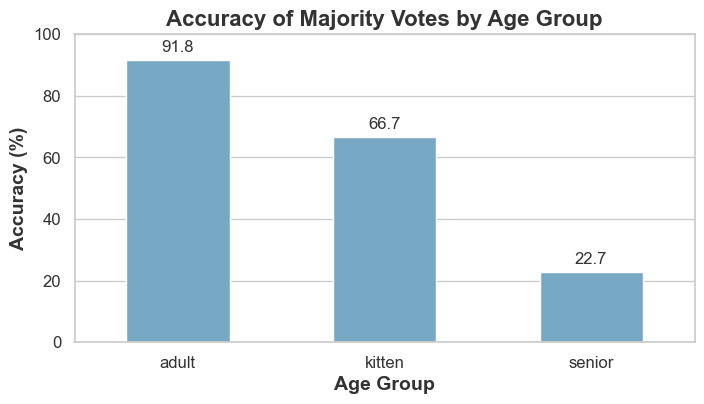

In [24]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [25]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_class_stats.append(class_stats)

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
  actual_age_group  total_count  correct_count   accuracy
0            adult          474            409  86.286920
1           kitten           91             50  54.945055
2           senior          149             44  29.530201


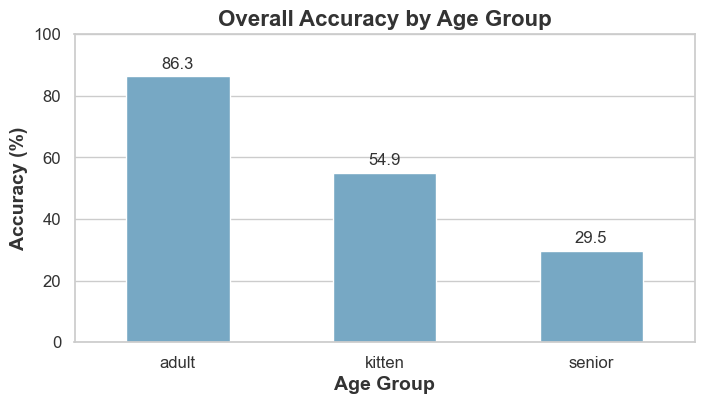

In [26]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [27]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    196      131     66.84
1          M    286      222     77.62
2          X    232      150     64.66


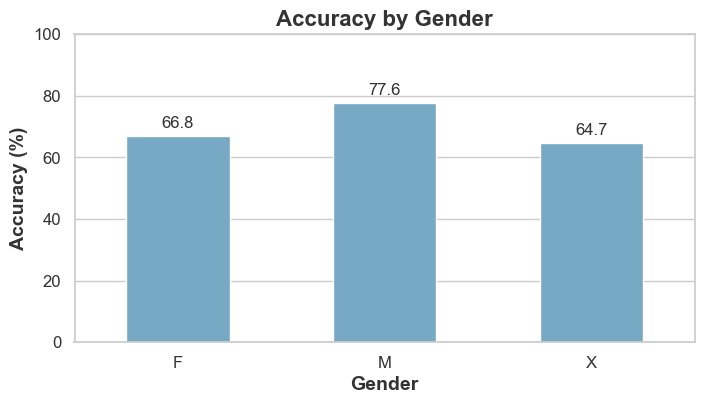

In [28]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [29]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.7454545454545455]
Total Class Statistics so far:
 [  actual_age_group  total_count  correct_count   accuracy
0            adult          474            409  86.286920
1           kitten           91             50  54.945055
2           senior          149             44  29.530201]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F    196      131     66.84
1          M    286      222     77.62
2          X    232      150     64.66]


# RANDOM SEED 2

In [30]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[1]))
np.random.seed(int(random_seeds[1]))
tf.random.set_seed(int(random_seeds[1]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/perch-2/scripts/perch_embeddings_april_10.csv')
augmented_df = pd.read_csv('/Users/astrid/PycharmProjects/perch-2/scripts/perch_embeddings_augmented_d3.csv')

dataframe.drop('mean_freq', axis=1, inplace=True)

augmented_df.drop('mean_freq', axis=1, inplace=True)
augmented_df.drop('gender', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)
augmented_df['age_group'] = augmented_df['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())
print(augmented_df['age_group'].value_counts())

adult     509
senior    149
kitten    135
Name: age_group, dtype: int64
senior    900
kitten    820
adult     758
Name: age_group, dtype: int64


In [31]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [32]:
tf.keras.backend.clear_session()

## Run Setup

In [33]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[1]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ######################
    # ADD AUGMENTED DATA #
    ######################

    # Filter out augmented data derived from groups in the training set
    augmented_df_filtered = augmented_df[augmented_df['cat_id'].isin(groups_train_val)]
    
    # Convert augmented_df_filtered to numpy array (excluding target and other columns)
    augmented_array = augmented_df_filtered.drop(columns=['target', 'cat_id', 'age_group']).values
    
    # Concatenate the filtered augmented data with X_train_val
    X_train_val = np.concatenate([X_train_val, augmented_array])

    # Extract target labels from the filtered augmented DataFrame
    y_augmented = augmented_df_filtered['age_group'].values
    
    # Encode the labels using the same LabelEncoder instance
    y_augmented_encoded = label_encoder.transform(y_augmented)
    
    # Concatenate the encoded augmented labels with y_train_val
    y_train_val = np.concatenate([y_train_val, y_augmented_encoded])

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.00510251984616472)
    }
    
    # Model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.2011047009431978))  
    model_full.add(Dense(256, activation='relu',)) 
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.14956886311951184))  
    model_full.add(Dense(256, activation='relu'))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.42291461228250665))  
    model_full.add(Dense(3, activation='softmax'))  
    
    # Use the optimizer from the parameters
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=64,
                                  verbose=1, callbacks=[early_stopping, accuracy_history])
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1
Train Set Group Distribution:
046A    45
103A    33
002B    30
047A    22
020A    20
000B    19
057A    17
019A    17
074A    16
029A    15
097A    15
097B    14
106A    13
101A    12
051A    12
055A    12
116A    12
111A    12
042A    11
028A    11
063A    11
040A    10
025A    10
059A    10
014B    10
016A     9
065A     9
051B     9
072A     9
001A     9
005A     9
022A     9
013B     8
068A     8
117A     7
027A     7
031A     7
007A     6
023A     6
039A     6
099A     6
075A     5
108A     5
094A     5
021A     5
008A     5
044A     5
070A     5
109A     5
003A     4
009A     4
045A     4
104A     4
026A     4
025C     4
113A     3
053A     3
056A     3
012A     3
058A     3
010A     3
060A     3
014A     3
025B     2
052A     2
037A     2
102A     2
087A     2
032A     2
110A     1
090A     1
024A     1
115A     1
076A     1
041A     1
019B     1
088A     1
048A     1
026C     1
049A     1
091A     1
073A     1
043A     1
026B     1
Name: cat_id, dtype: int64
Testin

Age group distribution: Counter({2: 875, 1: 785, 0: 769})
Epoch 1/1500
38/38 [==============================] - 1s 5ms/step - loss: 0.4660 - accuracy: 0.8378
Epoch 2/1500
38/38 [==============================] - 0s 5ms/step - loss: 0.0831 - accuracy: 0.9683
Epoch 3/1500
38/38 [==============================] - 0s 5ms/step - loss: 0.0434 - accuracy: 0.9864
Epoch 4/1500
38/38 [==============================] - 0s 6ms/step - loss: 0.0245 - accuracy: 0.9922
Epoch 5/1500
38/38 [==============================] - 0s 6ms/step - loss: 0.0160 - accuracy: 0.9938
Epoch 6/1500
38/38 [==============================] - 0s 6ms/step - loss: 0.0136 - accuracy: 0.9963
Epoch 7/1500
38/38 [==============================] - 0s 6ms/step - loss: 0.0119 - accuracy: 0.9963
Epoch 8/1500
38/38 [==============================] - 0s 6ms/step - loss: 0.0087 - accuracy: 0.9984
Epoch 9/1500
38/38 [==============================] - 0s 6ms/step - loss: 0.0121 - accuracy: 0.9959
Epoch 10/1500
38/38 [=====================

Majority Vote Accuracy for cat_id for this fold: 0.77 (23/30)
Before appending - Cat IDs: 109, Predictions: 109, Actuals: 109, Gender: 109
After appending - Cat IDs: 359, Predictions: 359, Actuals: 359, Gender: 359
Final Test Results - Loss: 1.8332140445709229, Accuracy: 0.7239999771118164, Precision: 0.5955387205387205, Recall: 0.494042994042994, F1 Score: 0.5305745628326274
Confusion Matrix:
 [[164   2  32]
 [ 11  14   1]
 [ 23   0   3]]
outer_fold 3
Train Set Group Distribution:
046A    45
000A    39
103A    33
002B    30
020A    20
000B    19
019A    17
074A    16
029A    15
097A    15
097B    14
002A    13
106A    13
101A    12
051A    12
028A    11
067A    11
042A    11
063A    11
014B    10
005A     9
016A     9
051B     9
065A     9
072A     9
071A     9
033A     9
068A     8
013B     8
036A     7
015A     7
095A     7
023A     6
099A     6
070A     5
094A     5
108A     5
075A     5
008A     5
044A     5
021A     5
050A     5
104A     4
026A     4
003A     4
023B     4
025C   

Testing Set Age Group Distribution BEFORE SWAP:
adult     117
senior     50
kitten     48
Name: age_group, dtype: int64
Train Age Group Distribution AFTER SWAP:
adult     392
kitten    131
senior     99
Name: age_group, dtype: int64
Testing Set Age Group Distribution AFTER SWAP:
adult     117
senior     50
kitten      4
Name: age_group, dtype: int64

 Starting training on unseen test set

Age group distribution: Counter({0: 983, 1: 931, 2: 719})
Epoch 1/1500
42/42 [==============================] - 1s 5ms/step - loss: 0.4714 - accuracy: 0.8390
Epoch 2/1500
42/42 [==============================] - 0s 5ms/step - loss: 0.0930 - accuracy: 0.9662
Epoch 3/1500
42/42 [==============================] - 0s 6ms/step - loss: 0.0619 - accuracy: 0.9784
Epoch 4/1500
42/42 [==============================] - 0s 6ms/step - loss: 0.0362 - accuracy: 0.9867
Epoch 5/1500
42/42 [==============================] - 0s 6ms/step - loss: 0.0227 - accuracy: 0.9901
Epoch 6/1500
42/42 [==============================

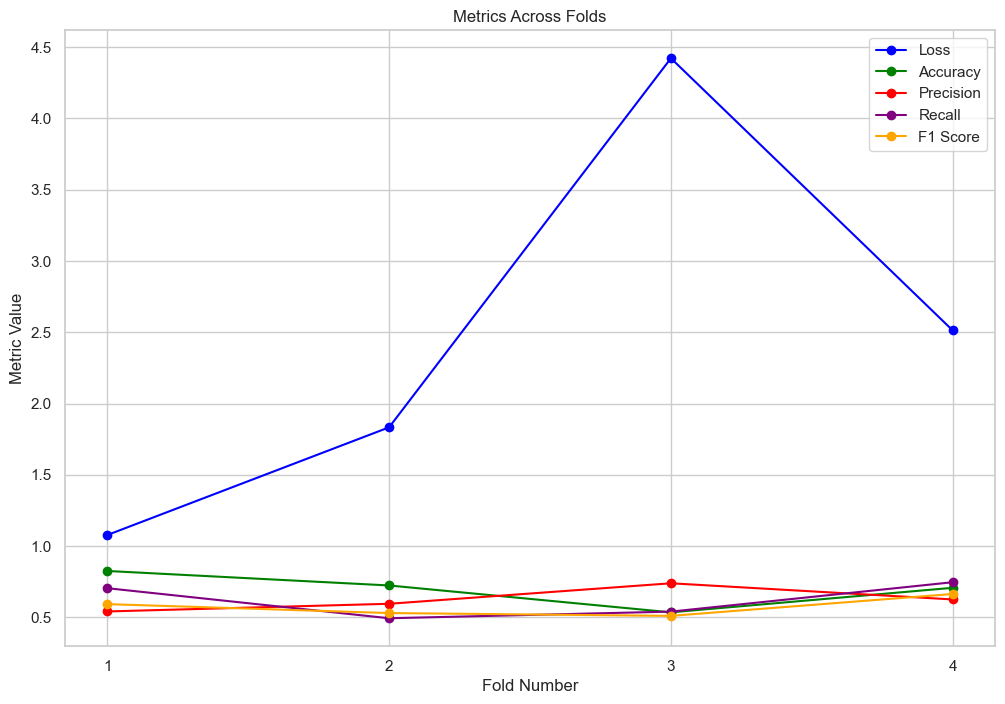

In [34]:
seed_2_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_2_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_2_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [35]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 713, Predictions: 713, Actuals: 713, Gender: 713


In [36]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [37]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.73 (80/110)


In [38]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [39]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, senior, adult, adult, adult, adult, ad...",adult,adult,True
45,039A,"[adult, adult, adult, adult, adult, adult]",adult,adult,True
80,074A,"[adult, adult, senior, adult, adult, adult, ad...",adult,adult,True
79,073A,[adult],adult,adult,True
78,072A,"[adult, adult, adult, senior, adult, adult, ad...",adult,adult,True
77,071A,"[adult, adult, adult, adult, adult, adult, sen...",adult,adult,True
76,070A,"[adult, adult, adult, adult, adult]",adult,adult,True
74,068A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
73,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
71,065A,"[senior, adult, adult, adult, adult, senior, a...",adult,adult,True


In [40]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
adult     65
kitten    10
senior     5
Name: Majority_Correct, dtype: int64


In [41]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group  total_count  correct_count   accuracy
0            adult           73             65  89.041096
1           kitten           15             10  66.666667
2           senior           22              5  22.727273


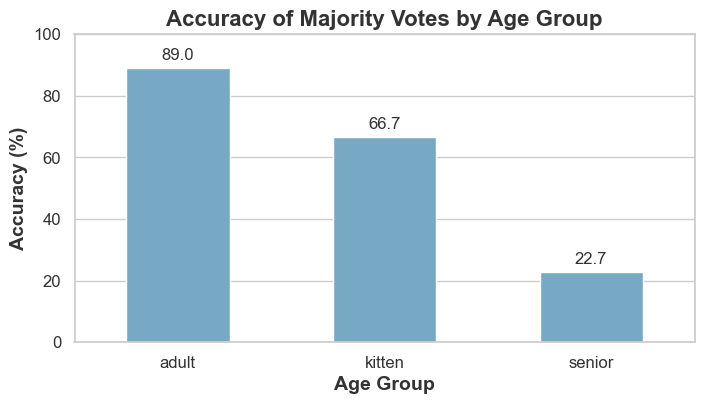

In [42]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [43]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_class_stats.append(class_stats)

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
  actual_age_group  total_count  correct_count   accuracy
0            adult          473            400  84.566596
1           kitten           91             52  57.142857
2           senior          149             38  25.503356


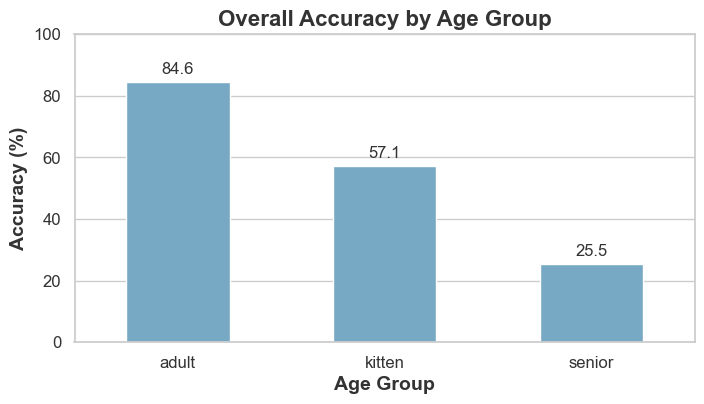

In [44]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [45]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    192      126     65.62
1          M    289      213     73.70
2          X    232      151     65.09


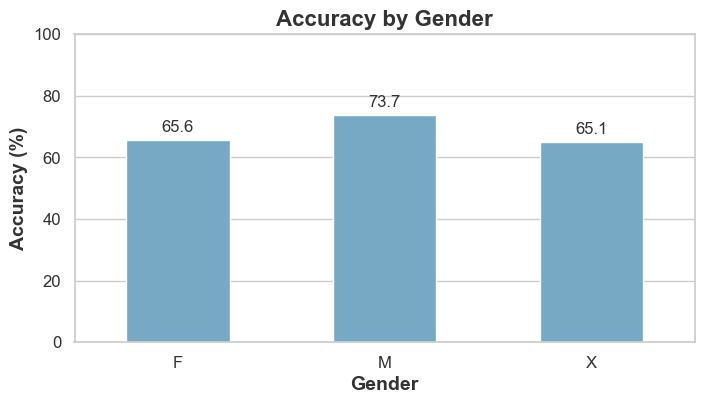

In [46]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [47]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.7454545454545455, 0.7272727272727273]
Total Class Statistics so far:
 [  actual_age_group  total_count  correct_count   accuracy
0            adult          474            409  86.286920
1           kitten           91             50  54.945055
2           senior          149             44  29.530201,   actual_age_group  total_count  correct_count   accuracy
0            adult          473            400  84.566596
1           kitten           91             52  57.142857
2           senior          149             38  25.503356]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F    196      131     66.84
1          M    286      222     77.62
2          X    232      150     64.66,   all_gender  count  correct  accuracy
0          F    192      126     65.62
1          M    289      213     73.70
2          X    232      151     65.09]


# RANDOM SEED 3

In [48]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[2]))
np.random.seed(int(random_seeds[2]))
tf.random.set_seed(int(random_seeds[2]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/perch-2/scripts/perch_embeddings_april_10.csv')
augmented_df = pd.read_csv('/Users/astrid/PycharmProjects/perch-2/scripts/perch_embeddings_augmented_d3.csv')

dataframe.drop('mean_freq', axis=1, inplace=True)

augmented_df.drop('mean_freq', axis=1, inplace=True)
augmented_df.drop('gender', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)
augmented_df['age_group'] = augmented_df['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())
print(augmented_df['age_group'].value_counts())

adult     509
senior    149
kitten    135
Name: age_group, dtype: int64
senior    900
kitten    820
adult     758
Name: age_group, dtype: int64


In [49]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [50]:
tf.keras.backend.clear_session()

## Run Setup

In [51]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[2]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ######################
    # ADD AUGMENTED DATA #
    ######################

    # Filter out augmented data derived from groups in the training set
    augmented_df_filtered = augmented_df[augmented_df['cat_id'].isin(groups_train_val)]
    
    # Convert augmented_df_filtered to numpy array (excluding target and other columns)
    augmented_array = augmented_df_filtered.drop(columns=['target', 'cat_id', 'age_group']).values
    
    # Concatenate the filtered augmented data with X_train_val
    X_train_val = np.concatenate([X_train_val, augmented_array])

    # Extract target labels from the filtered augmented DataFrame
    y_augmented = augmented_df_filtered['age_group'].values
    
    # Encode the labels using the same LabelEncoder instance
    y_augmented_encoded = label_encoder.transform(y_augmented)
    
    # Concatenate the encoded augmented labels with y_train_val
    y_train_val = np.concatenate([y_train_val, y_augmented_encoded])

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.00510251984616472)
    }
    
    # Model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.2011047009431978))  
    model_full.add(Dense(256, activation='relu',)) 
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.14956886311951184))  
    model_full.add(Dense(256, activation='relu'))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.42291461228250665))  
    model_full.add(Dense(3, activation='softmax'))  
    
    # Use the optimizer from the parameters
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=64,
                                  verbose=1, callbacks=[early_stopping, accuracy_history])
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1
Train Set Group Distribution:
046A    45
000A    39
103A    33
002B    30
047A    22
000B    19
057A    17
074A    16
097A    15
029A    15
002A    13
106A    13
051A    12
101A    12
116A    12
055A    12
111A    12
067A    11
063A    11
040A    10
025A    10
051B     9
016A     9
065A     9
072A     9
001A     9
005A     9
033A     9
022A     9
071A     9
013B     8
068A     8
015A     7
036A     7
031A     7
117A     7
027A     7
095A     7
007A     6
023A     6
044A     5
109A     5
021A     5
070A     5
094A     5
050A     5
108A     5
008A     5
026A     4
009A     4
025C     4
045A     4
104A     4
003A     4
058A     3
060A     3
012A     3
053A     3
006A     3
056A     3
113A     3
034A     3
035A     2
032A     2
025B     2
087A     2
038A     2
037A     2
061A     2
054A     2
004A     1
100A     1
110A     1
115A     1
088A     1
076A     1
048A     1
066A     1
096A     1
091A     1
026C     1
041A     1
049A     1
073A     1
024A     1
Name: cat_id, dtype: i

Epoch 1/1500
41/41 [==============================] - 1s 5ms/step - loss: 0.3852 - accuracy: 0.8629
Epoch 2/1500
41/41 [==============================] - 0s 5ms/step - loss: 0.0883 - accuracy: 0.9682
Epoch 3/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0369 - accuracy: 0.9872
Epoch 4/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0181 - accuracy: 0.9961
Epoch 5/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0205 - accuracy: 0.9938
Epoch 6/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0127 - accuracy: 0.9953
Epoch 7/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0134 - accuracy: 0.9973
Epoch 8/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0072 - accuracy: 0.9973
Epoch 9/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0088 - accuracy: 0.9973
Epoch 10/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0054 - accuracy: 0.9984

Age group distribution: Counter({0: 1005, 2: 731, 1: 667})
Epoch 1/1500
38/38 [==============================] - 1s 6ms/step - loss: 0.4739 - accuracy: 0.8398
Epoch 2/1500
38/38 [==============================] - 0s 5ms/step - loss: 0.1164 - accuracy: 0.9542
Epoch 3/1500
38/38 [==============================] - 0s 5ms/step - loss: 0.0535 - accuracy: 0.9792
Epoch 4/1500
38/38 [==============================] - 0s 6ms/step - loss: 0.0180 - accuracy: 0.9950
Epoch 5/1500
38/38 [==============================] - 0s 6ms/step - loss: 0.0193 - accuracy: 0.9933
Epoch 6/1500
38/38 [==============================] - 0s 6ms/step - loss: 0.0137 - accuracy: 0.9967
Epoch 7/1500
38/38 [==============================] - 0s 6ms/step - loss: 0.0130 - accuracy: 0.9954
Epoch 8/1500
38/38 [==============================] - 0s 6ms/step - loss: 0.0099 - accuracy: 0.9975
Epoch 9/1500
38/38 [==============================] - 0s 6ms/step - loss: 0.0083 - accuracy: 0.9967
Epoch 10/1500
38/38 [====================

Majority Vote Accuracy for cat_id for this fold: 0.76 (22/29)
Before appending - Cat IDs: 323, Predictions: 323, Actuals: 323, Gender: 323
After appending - Cat IDs: 509, Predictions: 509, Actuals: 509, Gender: 509
Final Test Results - Loss: 1.6781033277511597, Accuracy: 0.7311828136444092, Precision: 0.7764196587725999, Recall: 0.637805029109377, F1 Score: 0.6767319043181113
Confusion Matrix:
 [[96  1  7]
 [15 20  1]
 [25  1 20]]
outer_fold 4
Train Set Group Distribution:
000A    39
047A    22
020A    20
000B    19
019A    17
074A    16
097A    15
097B    14
106A    13
002A    13
111A    12
116A    12
101A    12
067A    11
042A    11
063A    11
028A    11
059A    10
014B    10
040A    10
065A     9
016A     9
051B     9
072A     9
033A     9
022A     9
005A     9
001A     9
013B     8
095A     7
015A     7
027A     7
039A     6
099A     6
007A     6
109A     5
044A     5
008A     5
108A     5
075A     5
021A     5
070A     5
025C     4
104A     4
026A     4
023B     4
045A     4
009A 

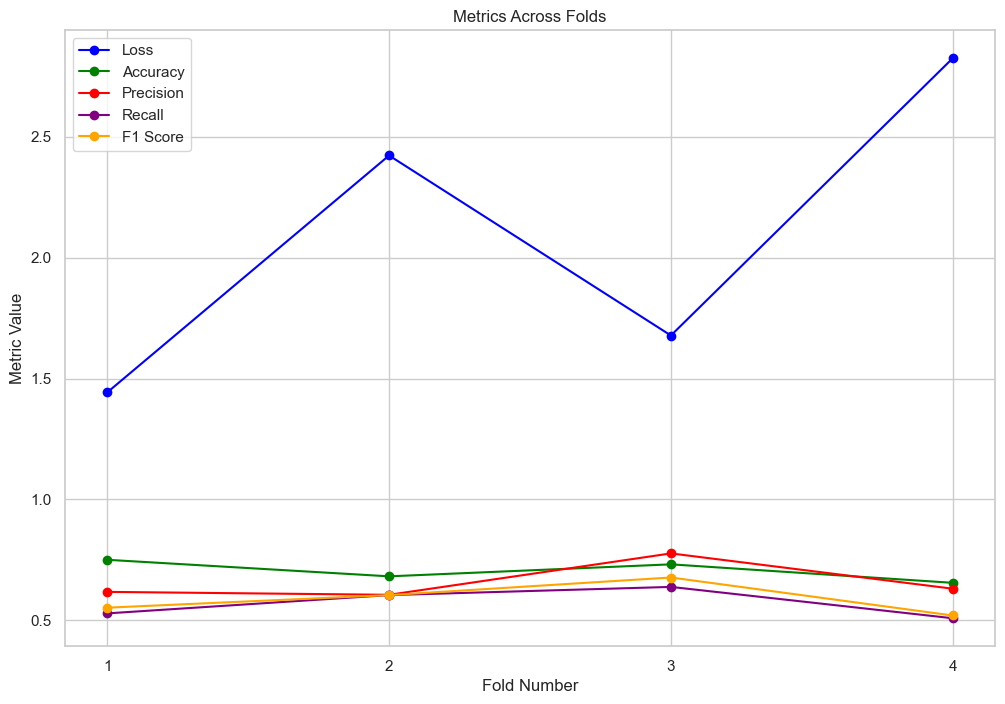

In [52]:
seed_3_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_3_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_3_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [53]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 732, Predictions: 732, Actuals: 732, Gender: 732


In [54]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [55]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.74 (81/110)


In [56]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [57]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
66,060A,"[adult, adult, kitten]",adult,adult,True
78,072A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
77,071A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
76,070A,"[adult, adult, adult, adult, adult]",adult,adult,True
74,068A,"[adult, adult, adult, adult, senior, adult, se...",adult,adult,True
73,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
71,065A,"[senior, adult, adult, adult, adult, adult, ad...",adult,adult,True
69,063A,"[adult, adult, adult, adult, kitten, senior, a...",adult,adult,True
68,062A,"[adult, adult, adult]",adult,adult,True


In [58]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
adult     64
kitten    11
senior     6
Name: Majority_Correct, dtype: int64


In [59]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group  total_count  correct_count   accuracy
0            adult           73             64  87.671233
1           kitten           15             11  73.333333
2           senior           22              6  27.272727


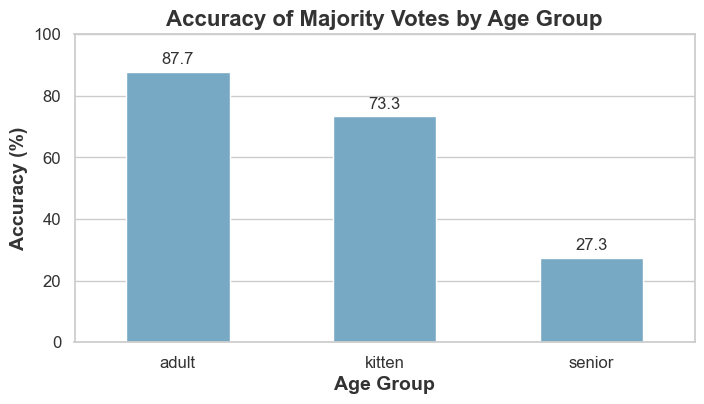

In [60]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [61]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_class_stats.append(class_stats)

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
  actual_age_group  total_count  correct_count   accuracy
0            adult          471            410  87.048832
1           kitten          112             59  52.678571
2           senior          149             43  28.859060


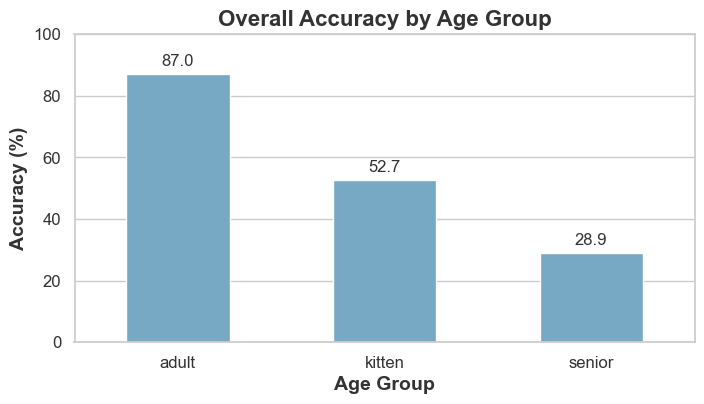

In [62]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [63]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    192      132     68.75
1          M    287      224     78.05
2          X    253      156     61.66


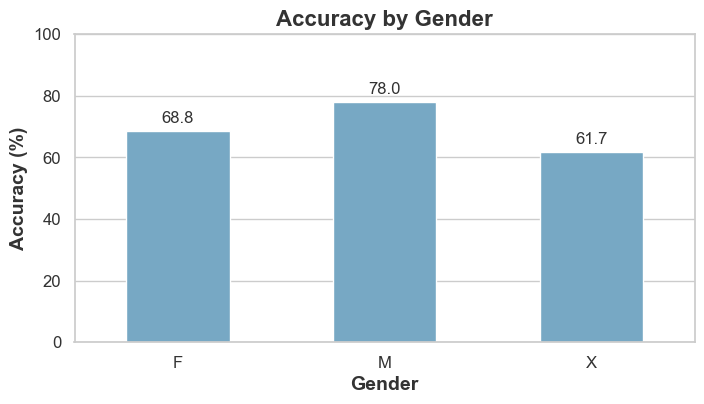

In [64]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [65]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.7454545454545455, 0.7272727272727273, 0.7363636363636363]
Total Class Statistics so far:
 [  actual_age_group  total_count  correct_count   accuracy
0            adult          474            409  86.286920
1           kitten           91             50  54.945055
2           senior          149             44  29.530201,   actual_age_group  total_count  correct_count   accuracy
0            adult          473            400  84.566596
1           kitten           91             52  57.142857
2           senior          149             38  25.503356,   actual_age_group  total_count  correct_count   accuracy
0            adult          471            410  87.048832
1           kitten          112             59  52.678571
2           senior          149             43  28.859060]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F    196      131     66.84
1          M    286      222     77.62
2          X    232  

# RANDOM SEED 4

In [66]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[3])) 
np.random.seed(int(random_seeds[3]))
tf.random.set_seed(int(random_seeds[3]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/perch-2/scripts/perch_embeddings_april_10.csv')
augmented_df = pd.read_csv('/Users/astrid/PycharmProjects/perch-2/scripts/perch_embeddings_augmented_d3.csv')

dataframe.drop('mean_freq', axis=1, inplace=True)

augmented_df.drop('mean_freq', axis=1, inplace=True)
augmented_df.drop('gender', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)
augmented_df['age_group'] = augmented_df['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())
print(augmented_df['age_group'].value_counts())

adult     509
senior    149
kitten    135
Name: age_group, dtype: int64
senior    900
kitten    820
adult     758
Name: age_group, dtype: int64


In [67]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [68]:
tf.keras.backend.clear_session()

## Run Setup

In [69]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[3]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ######################
    # ADD AUGMENTED DATA #
    ######################

    # Filter out augmented data derived from groups in the training set
    augmented_df_filtered = augmented_df[augmented_df['cat_id'].isin(groups_train_val)]
    
    # Convert augmented_df_filtered to numpy array (excluding target and other columns)
    augmented_array = augmented_df_filtered.drop(columns=['target', 'cat_id', 'age_group']).values
    
    # Concatenate the filtered augmented data with X_train_val
    X_train_val = np.concatenate([X_train_val, augmented_array])

    # Extract target labels from the filtered augmented DataFrame
    y_augmented = augmented_df_filtered['age_group'].values
    
    # Encode the labels using the same LabelEncoder instance
    y_augmented_encoded = label_encoder.transform(y_augmented)
    
    # Concatenate the encoded augmented labels with y_train_val
    y_train_val = np.concatenate([y_train_val, y_augmented_encoded])

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.00510251984616472)
    }
    
    # Model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.2011047009431978))  
    model_full.add(Dense(256, activation='relu',)) 
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.14956886311951184))  
    model_full.add(Dense(256, activation='relu'))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.42291461228250665))  
    model_full.add(Dense(3, activation='softmax'))  
    
    # Use the optimizer from the parameters
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=64,
                                  verbose=1, callbacks=[early_stopping, accuracy_history])
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1
Train Set Group Distribution:
046A    45
000A    39
103A    33
002B    30
047A    22
000B    19
057A    17
019A    17
074A    16
029A    15
097A    15
097B    14
002A    13
101A    12
111A    12
051A    12
028A    11
042A    11
067A    11
059A    10
014B    10
025A    10
065A     9
016A     9
072A     9
005A     9
022A     9
001A     9
013B     8
095A     7
027A     7
117A     7
031A     7
023A     6
021A     5
094A     5
050A     5
008A     5
109A     5
070A     5
108A     5
044A     5
045A     4
025C     4
009A     4
026A     4
012A     3
058A     3
010A     3
053A     3
006A     3
034A     3
014A     3
113A     3
105A     3
093A     2
025B     2
037A     2
102A     2
061A     2
035A     2
038A     2
052A     2
018A     2
032A     2
087A     2
041A     1
090A     1
100A     1
043A     1
110A     1
076A     1
115A     1
073A     1
064A     1
092A     1
019B     1
088A     1
004A     1
048A     1
066A     1
049A     1
091A     1
026B     1
Name: cat_id, dtype: int64
Testin

Epoch 1/1500
42/42 [==============================] - 1s 5ms/step - loss: 0.4694 - accuracy: 0.8469
Epoch 2/1500
42/42 [==============================] - 0s 5ms/step - loss: 0.1089 - accuracy: 0.9611
Epoch 3/1500
42/42 [==============================] - 0s 6ms/step - loss: 0.0572 - accuracy: 0.9813
Epoch 4/1500
42/42 [==============================] - 0s 6ms/step - loss: 0.0364 - accuracy: 0.9850
Epoch 5/1500
42/42 [==============================] - 0s 6ms/step - loss: 0.0225 - accuracy: 0.9918
Epoch 6/1500
42/42 [==============================] - 0s 6ms/step - loss: 0.0184 - accuracy: 0.9944
Epoch 7/1500
42/42 [==============================] - 0s 6ms/step - loss: 0.0164 - accuracy: 0.9955
Epoch 8/1500
42/42 [==============================] - 0s 6ms/step - loss: 0.0152 - accuracy: 0.9959
Epoch 9/1500
42/42 [==============================] - 0s 6ms/step - loss: 0.0078 - accuracy: 0.9981
Epoch 10/1500
42/42 [==============================] - 0s 6ms/step - loss: 0.0093 - accuracy: 0.9981

Train Age Group Distribution BEFORE SWAP:
adult     410
senior    112
kitten     45
Name: age_group, dtype: int64
Testing Set Age Group Distribution BEFORE SWAP:
adult     99
kitten    90
senior    37
Name: age_group, dtype: int64
Train Age Group Distribution AFTER SWAP:
adult     410
senior    112
kitten     89
Name: age_group, dtype: int64
Testing Set Age Group Distribution AFTER SWAP:
adult     99
kitten    46
senior    37
Name: age_group, dtype: int64

 Starting training on unseen test set

Age group distribution: Counter({0: 1031, 2: 788, 1: 585})
Epoch 1/1500
38/38 [==============================] - 1s 5ms/step - loss: 0.4208 - accuracy: 0.8615
Epoch 2/1500
38/38 [==============================] - 0s 5ms/step - loss: 0.0904 - accuracy: 0.9663
Epoch 3/1500
38/38 [==============================] - 0s 5ms/step - loss: 0.0552 - accuracy: 0.9834
Epoch 4/1500
38/38 [==============================] - 0s 6ms/step - loss: 0.0219 - accuracy: 0.9921
Epoch 5/1500
38/38 [=====================

Epoch 1/1500
41/41 [==============================] - 1s 5ms/step - loss: 0.4483 - accuracy: 0.8471
Epoch 2/1500
41/41 [==============================] - 0s 5ms/step - loss: 0.0876 - accuracy: 0.9671
Epoch 3/1500
41/41 [==============================] - 0s 5ms/step - loss: 0.0386 - accuracy: 0.9866
Epoch 4/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0263 - accuracy: 0.9912
Epoch 5/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0160 - accuracy: 0.9943
Epoch 6/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0135 - accuracy: 0.9962
Epoch 7/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0159 - accuracy: 0.9966
Epoch 8/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0133 - accuracy: 0.9954
Epoch 9/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0084 - accuracy: 0.9977
Epoch 10/1500
41/41 [==============================] - 0s 6ms/step - loss: 0.0075 - accuracy: 0.9969

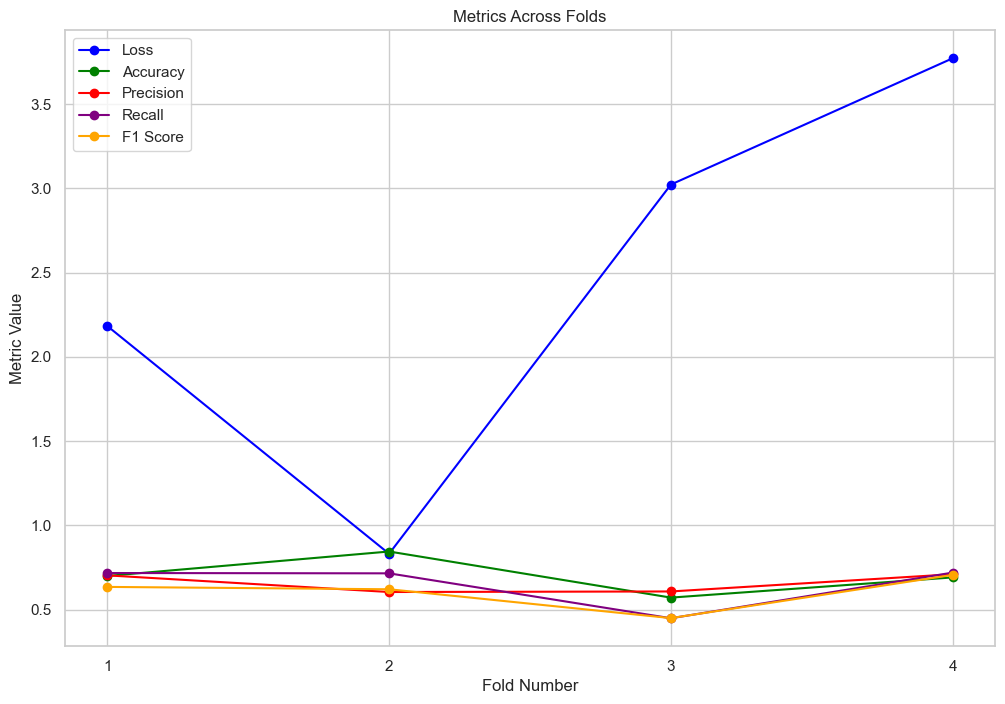

In [70]:
seed_4_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_4_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_4_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [71]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 711, Predictions: 711, Actuals: 711, Gender: 711


In [72]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [73]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.77 (85/110)


In [74]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [75]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, senior, adult, adult, adult, adult, ad...",adult,adult,True
71,065A,"[senior, adult, adult, adult, adult, senior, a...",adult,adult,True
80,074A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
79,073A,[adult],adult,adult,True
78,072A,"[adult, adult, adult, senior, adult, adult, ad...",adult,adult,True
77,071A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
76,070A,"[adult, adult, adult, adult, adult]",adult,adult,True
75,069A,"[adult, senior]",adult,adult,True
74,068A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
73,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True


In [76]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
adult     69
kitten    10
senior     6
Name: Majority_Correct, dtype: int64


In [77]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group  total_count  correct_count   accuracy
0            adult           73             69  94.520548
1           kitten           15             10  66.666667
2           senior           22              6  27.272727


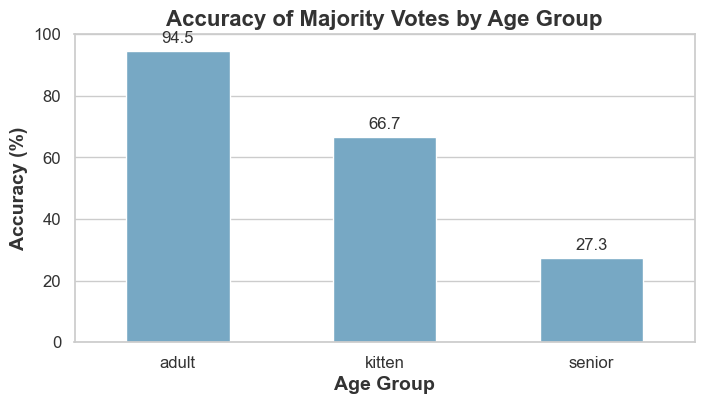

In [78]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [79]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_class_stats.append(class_stats)

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
  actual_age_group  total_count  correct_count   accuracy
0            adult          471            408  86.624204
1           kitten           91             47  51.648352
2           senior          149             47  31.543624


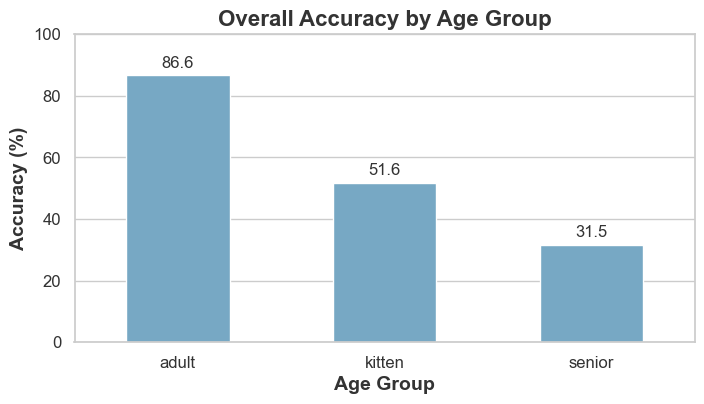

In [80]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [81]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    192      132     68.75
1          M    287      217     75.61
2          X    232      153     65.95


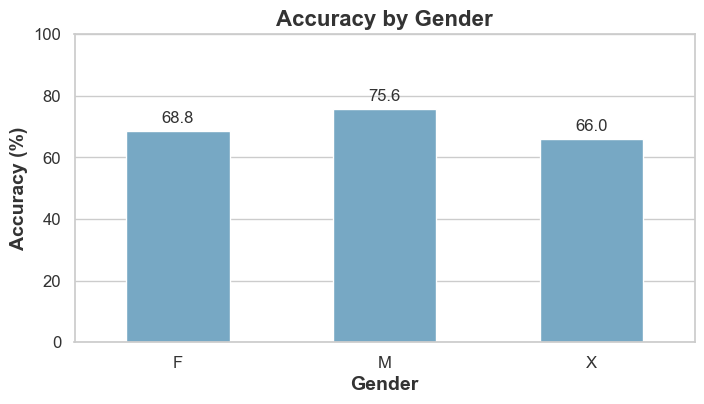

In [82]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [83]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.7454545454545455, 0.7272727272727273, 0.7363636363636363, 0.7727272727272727]
Total Class Statistics so far:
 [  actual_age_group  total_count  correct_count   accuracy
0            adult          474            409  86.286920
1           kitten           91             50  54.945055
2           senior          149             44  29.530201,   actual_age_group  total_count  correct_count   accuracy
0            adult          473            400  84.566596
1           kitten           91             52  57.142857
2           senior          149             38  25.503356,   actual_age_group  total_count  correct_count   accuracy
0            adult          471            410  87.048832
1           kitten          112             59  52.678571
2           senior          149             43  28.859060,   actual_age_group  total_count  correct_count   accuracy
0            adult          471            408  86.624204
1           kitten           91   

# RANDOM SEED 5

In [84]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[4]))
np.random.seed(int(random_seeds[4]))
tf.random.set_seed(int(random_seeds[4]))

# Load datasets
dataframe = pd.read_csv('/Users/astrid/PycharmProjects/perch-2/scripts/perch_embeddings_april_10.csv')
augmented_df = pd.read_csv('/Users/astrid/PycharmProjects/perch-2/scripts/perch_embeddings_augmented_d3.csv')

dataframe.drop('mean_freq', axis=1, inplace=True)

augmented_df.drop('mean_freq', axis=1, inplace=True)
augmented_df.drop('gender', axis=1, inplace=True)

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 12),
    'senior': (12, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)
augmented_df['age_group'] = augmented_df['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())
print(augmented_df['age_group'].value_counts())

adult     509
senior    149
kitten    135
Name: age_group, dtype: int64
senior    900
kitten    820
adult     758
Name: age_group, dtype: int64


In [85]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [86]:
tf.keras.backend.clear_session()

## Run Setup

In [87]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[4]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ######################
    # ADD AUGMENTED DATA #
    ######################

    # Filter out augmented data derived from groups in the training set
    augmented_df_filtered = augmented_df[augmented_df['cat_id'].isin(groups_train_val)]
    
    # Convert augmented_df_filtered to numpy array (excluding target and other columns)
    augmented_array = augmented_df_filtered.drop(columns=['target', 'cat_id', 'age_group']).values
    
    # Concatenate the filtered augmented data with X_train_val
    X_train_val = np.concatenate([X_train_val, augmented_array])

    # Extract target labels from the filtered augmented DataFrame
    y_augmented = augmented_df_filtered['age_group'].values
    
    # Encode the labels using the same LabelEncoder instance
    y_augmented_encoded = label_encoder.transform(y_augmented)
    
    # Concatenate the encoded augmented labels with y_train_val
    y_train_val = np.concatenate([y_train_val, y_augmented_encoded])

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.00510251984616472)
    }
    
    # Model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.2011047009431978))  
    model_full.add(Dense(256, activation='relu',)) 
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.14956886311951184))  
    model_full.add(Dense(256, activation='relu'))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.42291461228250665))  
    model_full.add(Dense(3, activation='softmax'))  
    
    # Use the optimizer from the parameters
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=64,
                                  verbose=1, callbacks=[early_stopping, accuracy_history])
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
    


outer_fold 1
Train Set Group Distribution:
046A    45
103A    33
002B    30
020A    20
019A    17
057A    17
074A    16
097A    15
029A    15
097B    14
106A    13
002A    13
051A    12
055A    12
111A    12
116A    12
063A    11
028A    11
067A    11
014B    10
059A    10
025A    10
065A     9
005A     9
071A     9
033A     9
001A     9
013B     8
068A     8
117A     7
095A     7
027A     7
031A     7
036A     7
039A     6
007A     6
050A     5
094A     5
108A     5
008A     5
075A     5
021A     5
044A     5
109A     5
104A     4
003A     4
025C     4
026A     4
009A     4
045A     4
023B     4
060A     3
056A     3
014A     3
012A     3
105A     3
053A     3
061A     2
037A     2
093A     2
054A     2
035A     2
025B     2
011A     2
038A     2
087A     2
069A     2
032A     2
110A     1
090A     1
019B     1
004A     1
100A     1
049A     1
048A     1
026C     1
041A     1
092A     1
096A     1
064A     1
091A     1
073A     1
043A     1
026B     1
Name: cat_id, dtype: int64
Testin

Majority Vote Accuracy for cat_id for this fold: 0.82 (23/28)
Before appending - Cat IDs: 0, Predictions: 0, Actuals: 0, Gender: 0
After appending - Cat IDs: 164, Predictions: 164, Actuals: 164, Gender: 164
Final Test Results - Loss: 3.0271451473236084, Accuracy: 0.6585366129875183, Precision: 0.7183312173790379, Recall: 0.49076555023923446, F1 Score: 0.5168498775056153
Confusion Matrix:
 [[89  4  2]
 [31 13  0]
 [19  0  6]]
outer_fold 2
Train Set Group Distribution:
046A    45
000A    39
002B    30
047A    22
020A    20
000B    19
019A    17
029A    15
002A    13
101A    12
055A    12
067A    11
028A    11
063A    11
042A    11
040A    10
059A    10
072A     9
016A     9
065A     9
051B     9
071A     9
001A     9
005A     9
022A     9
013B     8
068A     8
036A     7
117A     7
015A     7
027A     7
095A     7
099A     6
007A     6
023A     6
039A     6
108A     5
075A     5
070A     5
109A     5
050A     5
026A     4
104A     4
025C     4
023B     4
058A     3
010A     3
053A     3



Unique Test Group IDs:
['002B' '005A' '011A' '014A' '019A' '019B' '020A' '025C' '026B' '027A'
 '036A' '037A' '041A' '046A' '048A' '053A' '060A' '063A' '068A' '071A'
 '075A' '087A' '093A' '095A' '096A' '100A' '108A' '117A']
No common groups found between train and test sets.
Moved to Training/Validation Set:
{'046A'}
Removed from Training/Validation Set:
{'115A'}
Moved to Test Set:
{'115A'}
Removed from Test Set
{'046A'}
AFTER SWAP - Unique Training/Validation Group IDs:
['000A' '000B' '001A' '002A' '003A' '004A' '006A' '007A' '008A' '009A'
 '010A' '012A' '013B' '014B' '015A' '016A' '018A' '021A' '022A' '023A'
 '023B' '024A' '025A' '025B' '026A' '026C' '028A' '029A' '031A' '032A'
 '033A' '034A' '035A' '038A' '039A' '040A' '042A' '043A' '044A' '045A'
 '046A' '047A' '049A' '050A' '051A' '051B' '052A' '054A' '055A' '056A'
 '057A' '058A' '059A' '061A' '062A' '064A' '065A' '066A' '067A' '069A'
 '070A' '072A' '073A' '074A' '076A' '088A' '090A' '091A' '092A' '094A'
 '097A' '097B' '099A' '101A

Epoch 1/1500
42/42 [==============================] - 1s 5ms/step - loss: 0.4614 - accuracy: 0.8361
Epoch 2/1500
42/42 [==============================] - 0s 5ms/step - loss: 0.1142 - accuracy: 0.9546
Epoch 3/1500
42/42 [==============================] - 0s 6ms/step - loss: 0.0483 - accuracy: 0.9831
Epoch 4/1500
42/42 [==============================] - 0s 6ms/step - loss: 0.0345 - accuracy: 0.9891
Epoch 5/1500
42/42 [==============================] - 0s 6ms/step - loss: 0.0206 - accuracy: 0.9944
Epoch 6/1500
42/42 [==============================] - 0s 6ms/step - loss: 0.0128 - accuracy: 0.9966
Epoch 7/1500
42/42 [==============================] - 0s 6ms/step - loss: 0.0131 - accuracy: 0.9959
Epoch 8/1500
42/42 [==============================] - 0s 6ms/step - loss: 0.0116 - accuracy: 0.9962
Epoch 9/1500
42/42 [==============================] - 0s 6ms/step - loss: 0.0088 - accuracy: 0.9977
Epoch 10/1500
42/42 [==============================] - 0s 6ms/step - loss: 0.0082 - accuracy: 0.9981

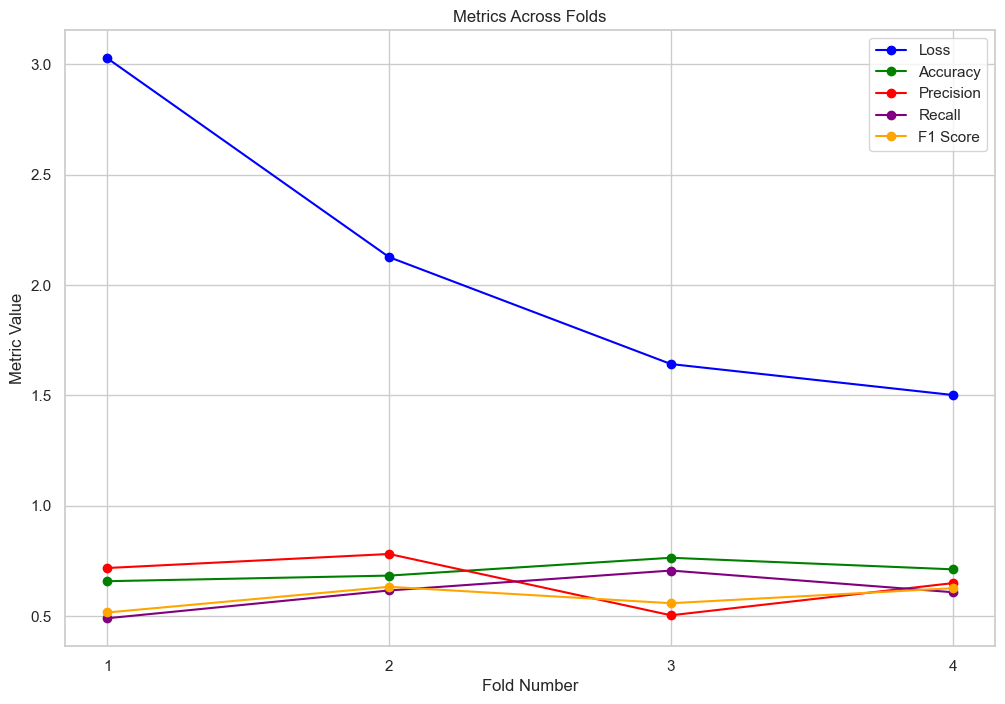

In [88]:
seed_5_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_5_training_acc_values = cv_training_acc_total

# Plotting all fold metrics|
seed_5_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [89]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 711, Predictions: 711, Actuals: 711, Gender: 711


In [90]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [91]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.76 (84/110)


In [92]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [93]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
70,064A,[adult],adult,adult,True
79,073A,[adult],adult,adult,True
78,072A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
77,071A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
76,070A,"[adult, adult, adult, adult, adult]",adult,adult,True
75,069A,"[adult, senior]",adult,adult,True
74,068A,"[adult, senior, adult, adult, senior, adult, s...",adult,adult,True
73,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
72,066A,[adult],adult,adult,True


In [94]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']

# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()

# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')

# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Count correct majority votes per class
correct_majority_votes_per_class = majority_with_actual.groupby('actual_age_group')['Majority_Correct'].sum()

print("Correct Majority Votes per Class:")
print(correct_majority_votes_per_class)

Correct Majority Votes per Class:
actual_age_group
adult     68
kitten    10
senior     6
Name: Majority_Correct, dtype: int64


In [95]:
# Calculate the total count and the number of correct predictions for each class
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    total_count=('Majority_Correct', 'size'),  # Total number of cases per class
    correct_count=('Majority_Correct', 'sum')  # Sum of correct predictions per class
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group  total_count  correct_count   accuracy
0            adult           73             68  93.150685
1           kitten           15             10  66.666667
2           senior           22              6  27.272727


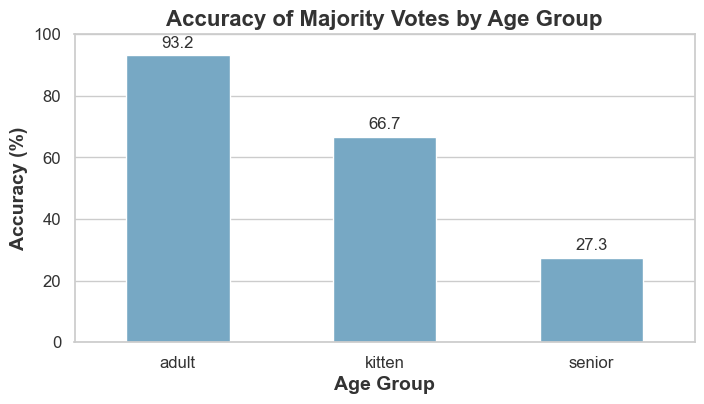

In [96]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [97]:
# Calculate the total count and the number of correct predictions for each class
class_stats = full_results.groupby('actual_age_group').agg(
    total_count=('correct', 'size'),
    correct_count=('correct', 'sum')
).reset_index()

# Calculate accuracy for each class
class_stats['accuracy'] = class_stats['correct_count'] / class_stats['total_count'] * 100

# store for final evaluation 
all_class_stats.append(class_stats)

# Log the detailed stats
print("Detailed Class Statistics:")
print(class_stats)

Detailed Class Statistics:
  actual_age_group  total_count  correct_count   accuracy
0            adult          471            412  87.473461
1           kitten           91             43  47.252747
2           senior          149             45  30.201342


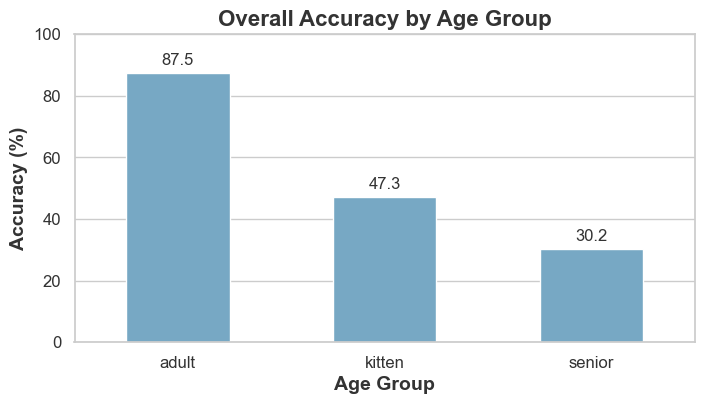

In [98]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [99]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    192      133     69.27
1          M    286      224     78.32
2          X    233      143     61.37


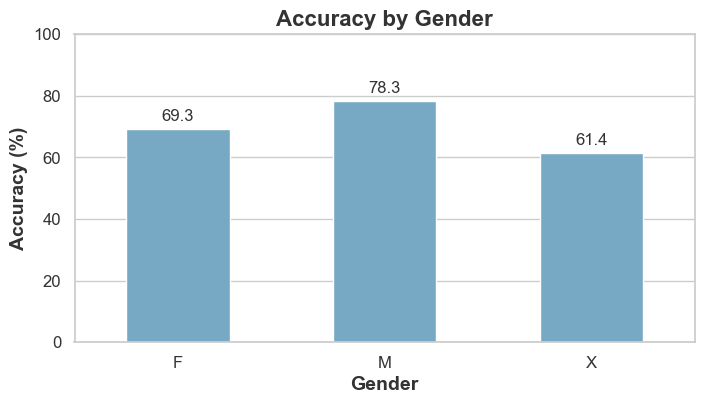

In [100]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [101]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats) 
print("Total Majority Vote Statistics so far:\n", all_majority_vote_details) 
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.7454545454545455, 0.7272727272727273, 0.7363636363636363, 0.7727272727272727, 0.7636363636363637]
Total Class Statistics so far:
 [  actual_age_group  total_count  correct_count   accuracy
0            adult          474            409  86.286920
1           kitten           91             50  54.945055
2           senior          149             44  29.530201,   actual_age_group  total_count  correct_count   accuracy
0            adult          473            400  84.566596
1           kitten           91             52  57.142857
2           senior          149             38  25.503356,   actual_age_group  total_count  correct_count   accuracy
0            adult          471            410  87.048832
1           kitten          112             59  52.678571
2           senior          149             43  28.859060,   actual_age_group  total_count  correct_count   accuracy
0            adult          471            408  86.624204
1           ki

# --------------

# Total Final Results & Analysis

In [102]:
# Count unique cat_id per age group 
unique_cats_per_age_group = dataframe.groupby('age_group')['cat_id'].nunique()

# Display the counts
print("Unique cat_id counts in original dataframe:", unique_cats_per_age_group)

Unique cat_id counts in original dataframe: age_group
adult     74
kitten    16
senior    22
Name: cat_id, dtype: int64


## Metrics

In [103]:
# Calculate overall metrics
overall_avg_loss = np.mean(all_losses)
overall_avg_acc = np.mean(all_accuracies)
overall_avg_precision = np.mean(all_precisions)
overall_avg_recall = np.mean(all_recalls)
overall_avg_f1 = np.mean(all_f1)

print("Overall Average Metrics:")
print("Loss:", overall_avg_loss)
print("Accuracy:", overall_avg_acc)
print("Precision:", overall_avg_precision)
print("Recall:", overall_avg_recall)
print("F1 Score:", overall_avg_f1)

Overall Average Metrics:
Loss: 2.3351282835006715
Accuracy: 0.7017180800437928
Precision: 0.6484727546386674
Recall: 0.6121980538562749
F1 Score: 0.5906314207686019


## Majority Votes

In [104]:
# Average of majority vote accuracies
average_majority_vote_accuracy = np.mean(all_majority_vote_accuracies)
print("Average Majority Vote Accuracy:", average_majority_vote_accuracy)

Average Majority Vote Accuracy: 0.749090909090909


In [105]:
# Concatenate all class stats DataFrames and calculate the mean of accuracies
total_majority_vote_details = pd.concat(all_majority_vote_details)
average_majority_vote_details = total_majority_vote_details.groupby('actual_age_group').agg({
    'total_count': 'sum', 
    'correct_count': 'sum' 
}).reset_index()
average_majority_vote_details['accuracy'] = (average_majority_vote_details['correct_count'] / average_majority_vote_details['total_count']) * 100

print("Average Class Statistics:")
print(average_majority_vote_details)

Average Class Statistics:
  actual_age_group  total_count  correct_count   accuracy
0            adult          365            333  91.232877
1           kitten           75             51  68.000000
2           senior          110             28  25.454545


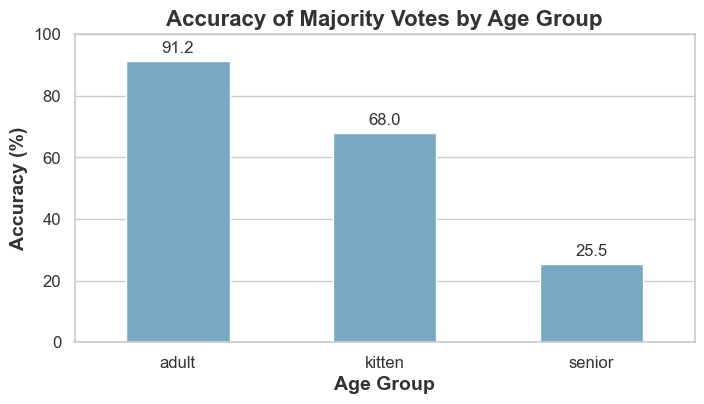

In [106]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(average_majority_vote_details, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')

## Detailed Class Statistics

In [107]:
# Concatenate all class stats DataFrames and calculate the mean of accuracies
total_class_stats = pd.concat(all_class_stats)
average_class_stats = total_class_stats.groupby('actual_age_group').agg({
    'total_count': 'sum',  
    'correct_count': 'sum' 
}).reset_index()
average_class_stats['accuracy'] = (average_class_stats['correct_count'] / average_class_stats['total_count']) * 100

print("Average Class Statistics:")
print(average_class_stats)

Average Class Statistics:
  actual_age_group  total_count  correct_count   accuracy
0            adult         2360           2039  86.398305
1           kitten          476            251  52.731092
2           senior          745            217  29.127517


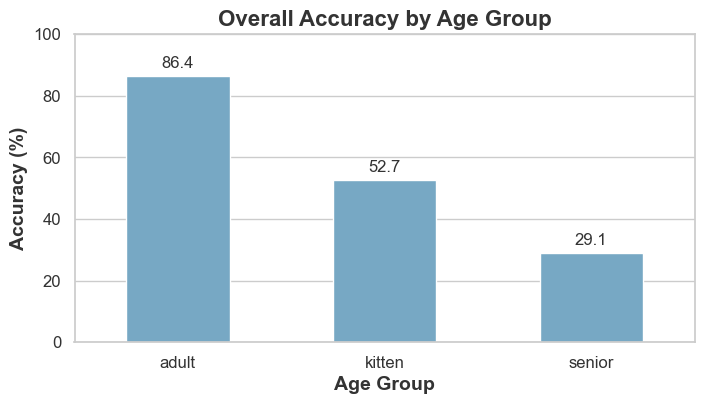

In [108]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(average_class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

In [109]:
# Concatenate all gender stats DataFrames and calculate the mean of accuracies
total_gender_stats = pd.concat(all_gender_stats)
average_gender_stats = total_gender_stats.groupby('all_gender').agg({
    'count': 'sum',  
    'correct': 'sum'  
}).reset_index()
average_gender_stats['accuracy'] = (average_gender_stats['correct'] / average_gender_stats['count']) * 100

print("Average Gender Accuracy:")
print(average_gender_stats)

Average Gender Accuracy:
  all_gender  count  correct   accuracy
0          F    964      654  67.842324
1          M   1435     1100  76.655052
2          X   1182      753  63.705584


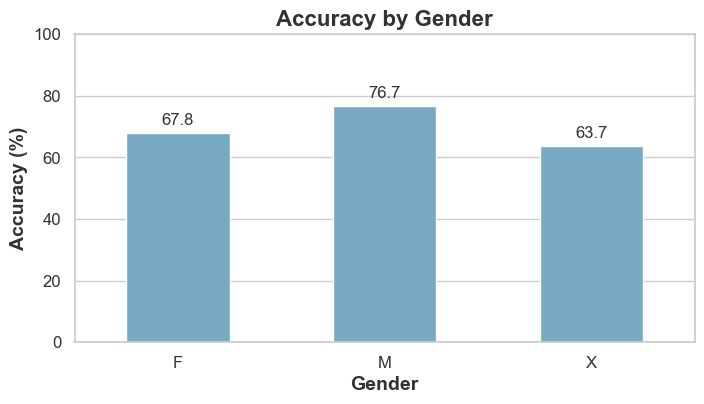

In [110]:
# Plot for Accuracy by Gender
styled_barplot(total_gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

# Visualisations

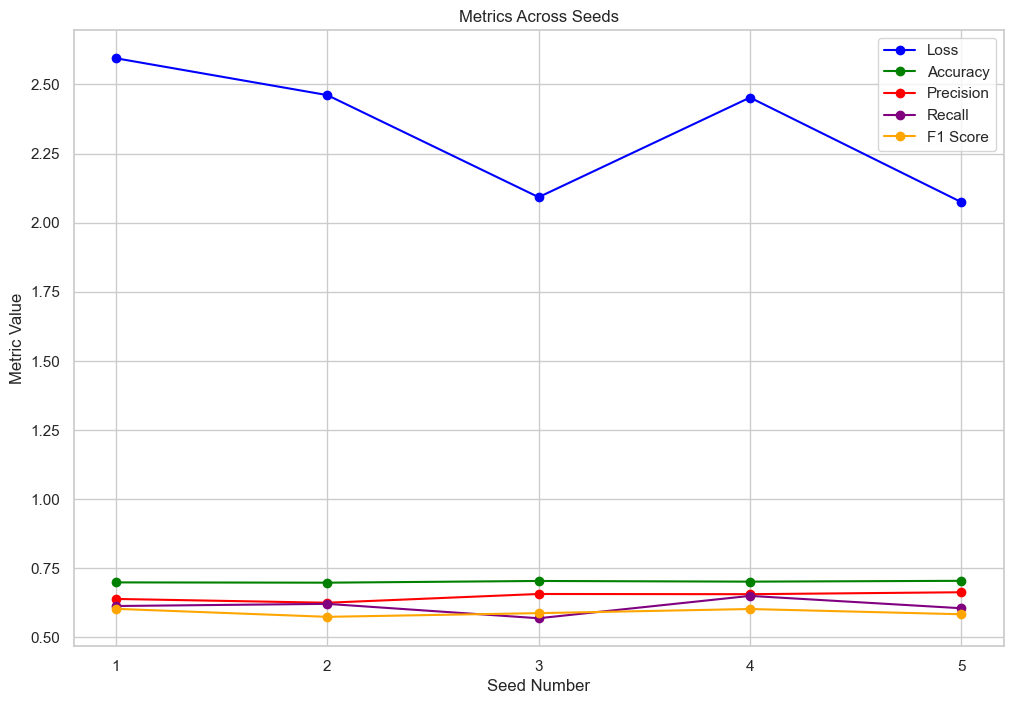

In [111]:
# Plotting all metrics
metrics_across_seeds = plot_all_metrics(average_fold_losses, average_fold_accuracies, average_fold_precisions, average_fold_recalls, average_fold_f1, "Seeds", "Seed Number")

## Display the seed folds results together

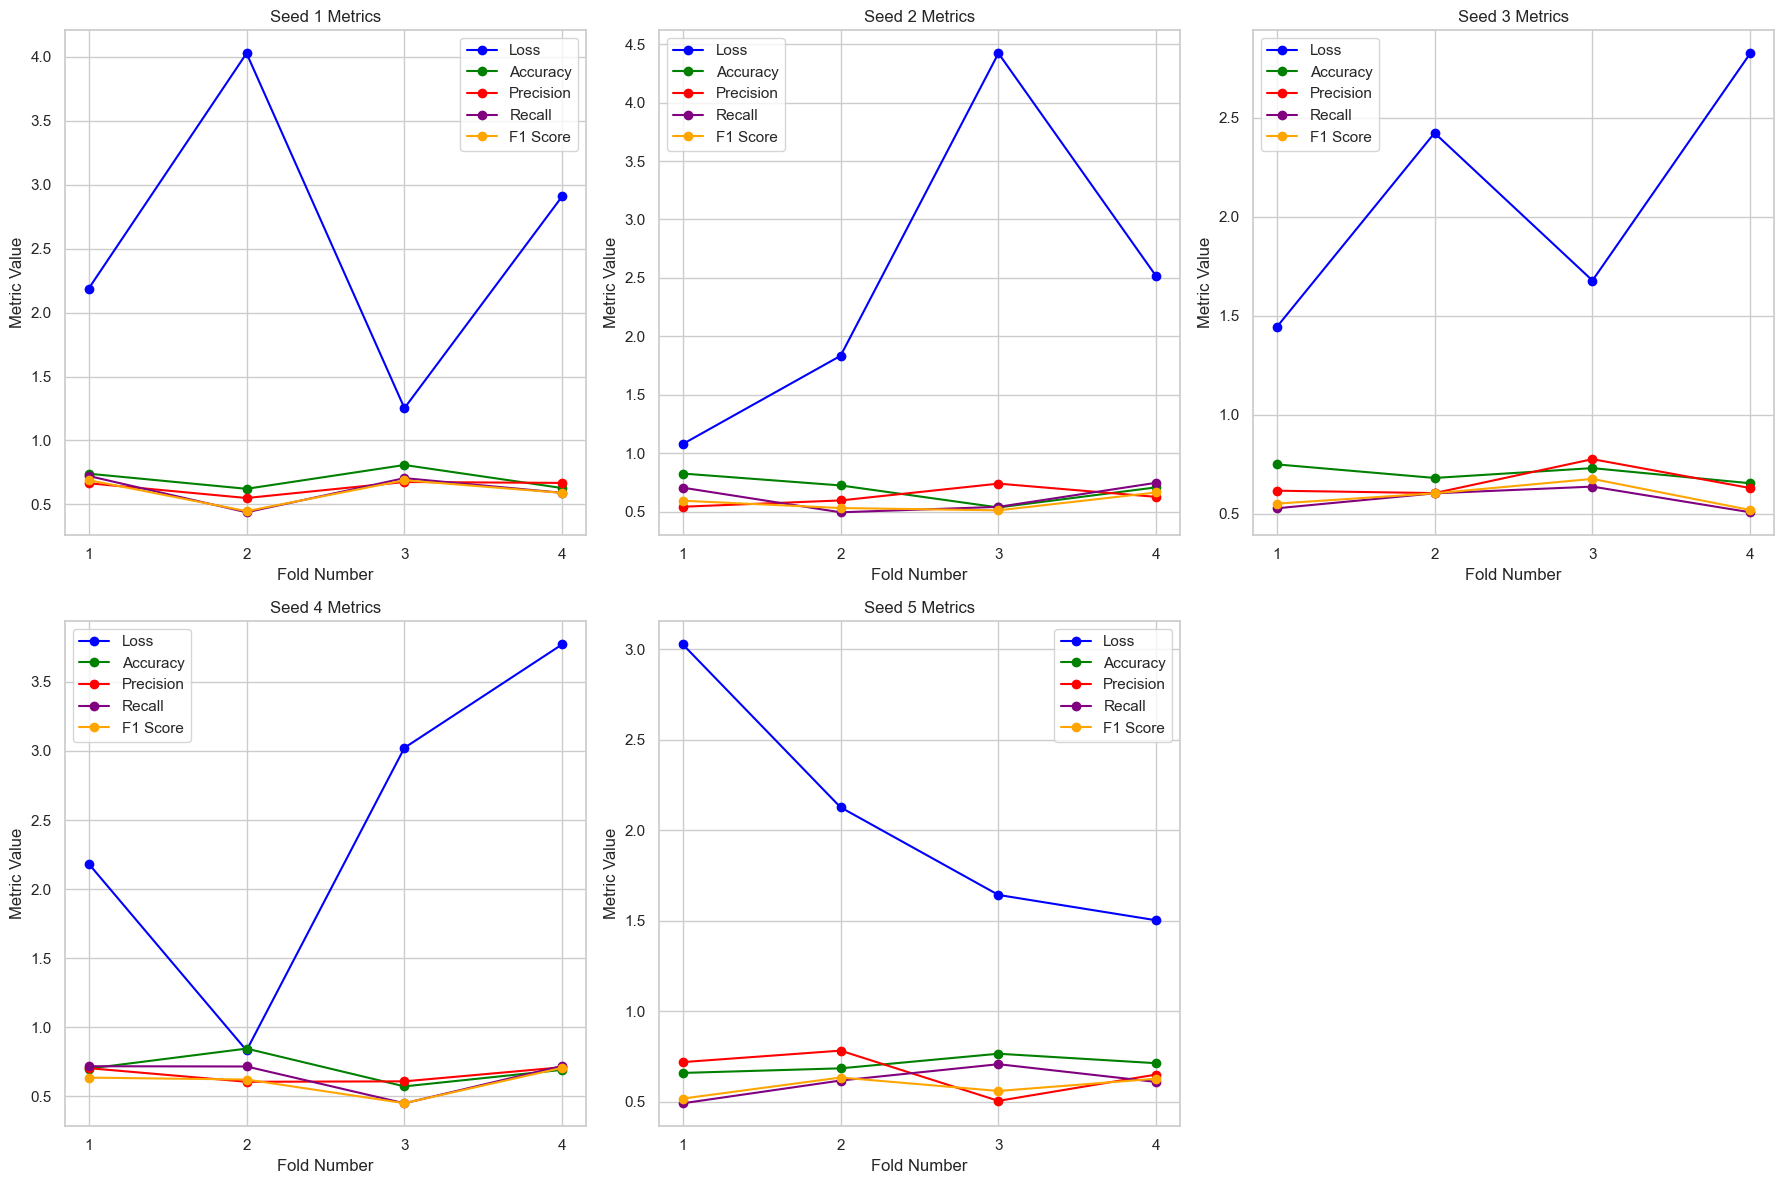

In [112]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))  

# Flatten the axes array for easier indexing
axes = axes.flatten()

def plot_metrics_on_axes(ax, losses, accuracies, precisions, recalls, f1, title):
    ax.plot(range(1, len(losses)+1), losses, marker='o', color='blue', label='Loss')
    ax.plot(range(1, len(accuracies)+1), accuracies, marker='o', color='green', label='Accuracy')
    ax.plot(range(1, len(precisions)+1), precisions, marker='o', color='red', label='Precision')
    ax.plot(range(1, len(recalls)+1), recalls, marker='o', color='purple', label='Recall')
    ax.plot(range(1, len(f1)+1), f1, marker='o', color='orange', label='F1 Score')
    ax.set_xticks([1, 2, 3, 4])  # Set x-axis ticks to full integers
    ax.set_title(title)
    ax.set_xlabel('Fold Number')
    ax.set_ylabel('Metric Value')
    ax.legend()
    ax.grid(True)

# Plot onto each axes object
plot_metrics_on_axes(axes[0], *seed_1_folds_values, "Seed 1 Metrics")
plot_metrics_on_axes(axes[1], *seed_2_folds_values, "Seed 2 Metrics")
plot_metrics_on_axes(axes[2], *seed_3_folds_values, "Seed 3 Metrics")
plot_metrics_on_axes(axes[3], *seed_4_folds_values, "Seed 4 Metrics")
plot_metrics_on_axes(axes[4], *seed_5_folds_values, "Seed 5 Metrics")

# Hide the unused subplot 
for ax in axes[5:]:
    ax.set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

# Statistics

### Standard Deviation

In [113]:
# Calculate the standard deviation for each metric
std_loss = np.std(all_losses)
std_accuracy = np.std(all_accuracies)
std_precision = np.std(all_precisions)
std_recall = np.std(all_recalls)
std_f1 = np.std(all_f1)

print("Standard Deviations:")
print(f"Loss: {std_loss}")
print(f"Accuracy: {std_accuracy}")
print(f"Precision: {std_precision}")
print(f"Recall: {std_recall}")
print(f"F1 Score: {std_f1}")

Standard Deviations:
Loss: 0.9645118576526373
Accuracy: 0.07676975170544677
Precision: 0.07332033271416062
Recall: 0.09991040778427335
F1 Score: 0.07589880064573121


### Interquartile Range

In [114]:
# Calculate the interquartile range for each metric
iqr_loss = np.percentile(all_losses, 75) - np.percentile(all_losses, 25)
iqr_accuracy = np.percentile(all_accuracies, 75) - np.percentile(all_accuracies, 25)
iqr_precision = np.percentile(all_precisions, 75) - np.percentile(all_precisions, 25)
iqr_recall = np.percentile(all_recalls, 75) - np.percentile(all_recalls, 25)
iqr_f1 = np.percentile(all_f1, 75) - np.percentile(all_f1, 25)

print("Interquartile Ranges:")
print(f"Loss: {iqr_loss}")
print(f"Accuracy: {iqr_accuracy}")
print(f"Precision: {iqr_precision}")
print(f"Recall: {iqr_recall}")
print(f"F1 Score: {iqr_f1}")


Interquartile Ranges:
Loss: 1.3316879868507385
Accuracy: 0.08483369648456573
Precision: 0.10012435728091706
Recall: 0.1857370249738306
F1 Score: 0.11443146808815785


### Variation

In [115]:
# Calculate the variation for each metric
var_loss = np.var(all_losses)
var_accuracy = np.var(all_accuracies)
var_precision = np.var(all_precisions)
var_recall = np.var(all_recalls)
var_f1 = np.var(all_f1)

print("Variations:")
print(f"Loss: {var_loss}")
print(f"Accuracy: {var_accuracy}")
print(f"Precision: {var_precision}")
print(f"Recall: {var_recall}")
print(f"F1 Score: {var_f1}")

Variations:
Loss: 0.9302831235525412
Accuracy: 0.005893594776915948
Precision: 0.005375871189315212
Recall: 0.00998208958361979
F1 Score: 0.005760627939460448


### Levene tests for variation significance between seeds

#### Levene across seeds for LOSS

In [116]:
# Levene across seeds for LOSS
stat_val, p_val = levene(seed_1_folds_values[0], seed_2_folds_values[0], seed_3_folds_values[0], seed_4_folds_values[0], seed_5_folds_values[0])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 0.62, P-value: 0.656


#### Levene across seeds for ACCURACY

In [117]:
# Levene across seeds for ACCURACY
stat_val, p_val = levene(seed_1_folds_values[1], seed_2_folds_values[1], seed_3_folds_values[1], seed_4_folds_values[1], seed_5_folds_values[1])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 0.62, P-value: 0.655


#### Levene across seeds for PRECISION

In [118]:
# Levene across seeds for PRECISION
stat_val, p_val = levene(seed_1_folds_values[2], seed_2_folds_values[2], seed_3_folds_values[2], seed_4_folds_values[2], seed_5_folds_values[2])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 0.51, P-value: 0.730


#### Levene across seeds for RECALL

In [119]:
# Levene across seeds for RECALL
stat_val, p_val = levene(seed_1_folds_values[3], seed_2_folds_values[3], seed_3_folds_values[3], seed_4_folds_values[3], seed_5_folds_values[3])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 0.44, P-value: 0.779


#### Levene across seeds for F1

In [120]:
# Levene across seeds for F1
stat_val, p_val = levene(seed_1_folds_values[4], seed_2_folds_values[4], seed_3_folds_values[4], seed_4_folds_values[4], seed_5_folds_values[4])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 0.34, P-value: 0.846


## Print out measurements for future further analysis (without rerunning notebook)

In [121]:
seed_1_folds_values

[[2.1876420974731445, 4.027976036071777, 1.252773404121399, 2.910660982131958],
 [0.7398843765258789,
  0.6216216087341309,
  0.807881772518158,
  0.6274510025978088],
 [0.6652421652421653,
  0.5496031746031746,
  0.6749482401656315,
  0.6677226813590451],
 [0.7219127792898284,
  0.4379012345679012,
  0.7051069703243616,
  0.5900937081659973],
 [0.6894607159460716,
  0.44679186228482,
  0.6883371501062655,
  0.5897893972403777]]

In [122]:
seed_2_folds_values

[[1.0778368711471558,
  1.8332140445709229,
  4.422096252441406,
  2.512807846069336],
 [0.8256880640983582,
  0.7239999771118164,
  0.5355191230773926,
  0.707602322101593],
 [0.5416666666666667,
  0.5955387205387205,
  0.739307732008462,
  0.6259633699633699],
 [0.7048611111111112,
  0.494042994042994,
  0.540609122060735,
  0.7468376068376069],
 [0.5931222984998729,
  0.5305745628326274,
  0.510747340852925,
  0.6641904231281147]]

In [123]:
seed_3_folds_values

[[1.442808747291565, 2.422973394393921, 1.6781033277511597, 2.825324058532715],
 [0.75, 0.6815642714500427, 0.7311828136444092, 0.6547085046768188],
 [0.6172461797461798,
  0.6051229403008059,
  0.7764196587725999,
  0.6304093567251462],
 [0.5282733880864722, 0.6039426523297492, 0.637805029109377, 0.50812693498452],
 [0.551881138574687,
  0.6039447887472204,
  0.6767319043181113,
  0.5195126107702795]]

In [124]:
seed_4_folds_values

[[2.183525323867798,
  0.8316957950592041,
  3.0229897499084473,
  3.772618532180786],
 [0.699999988079071,
  0.8450000286102295,
  0.5714285969734192,
  0.6912751793861389],
 [0.7034649476228848,
  0.6046296029435781,
  0.6079182630906769,
  0.7101010101010101],
 [0.7173645320197043,
  0.7154481792717088,
  0.4489074054291446,
  0.7198635976129583],
 [0.6349239161642262,
  0.6209544058587291,
  0.4497462919594068,
  0.7061403508771931]]

In [125]:
seed_5_folds_values

[[3.0271451473236084,
  2.126350164413452,
  1.6420984268188477,
  1.5019254684448242],
 [0.6585366129875183,
  0.6839826703071594,
  0.7647058963775635,
  0.7123287916183472],
 [0.7183312173790379,
  0.7818104062722737,
  0.5041771094402673,
  0.6498316498316499],
 [0.49076555023923446,
  0.6166123412386196,
  0.7068156732891833,
  0.6086702671142898],
 [0.5168498775056153,
  0.6332607116920842,
  0.5588487446417636,
  0.6268199233716475]]

## Training Accuracy Analysis

In [126]:
all_best_training_acc

[0.9996196031570435,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9995883107185364,
 1.0,
 0.9996201992034912,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9995493292808533,
 1.0,
 0.9996249079704285]

In [127]:
total_training_acc

[[0.8489919900894165,
  0.965766429901123,
  0.9847850799560547,
  0.9904906749725342,
  0.9912514090538025,
  0.9961962699890137,
  0.9977177381515503,
  0.9961962699890137,
  0.9977177381515503,
  0.9958158731460571,
  0.9984785318374634,
  0.996957004070282,
  0.9965766668319702,
  0.996957004070282,
  0.9980981349945068,
  0.9965766668319702,
  0.9980981349945068,
  0.9980981349945068,
  0.9977177381515503,
  0.9942944049835205,
  0.9954355359077454,
  0.9988588690757751,
  0.9977177381515503,
  0.9980981349945068,
  0.9996196031570435,
  0.9992392659187317,
  0.9977177381515503,
  0.9965766668319702,
  0.9965766668319702,
  0.9977177381515503,
  0.9992392659187317,
  0.9973374009132385,
  0.9954355359077454,
  0.996957004070282,
  0.9996196031570435,
  0.9996196031570435,
  0.9992392659187317,
  0.9973374009132385,
  0.9988588690757751,
  0.9950551390647888,
  0.9977177381515503,
  0.9992392659187317,
  0.9984785318374634,
  0.9984785318374634,
  0.9977177381515503,
  0.9958158731

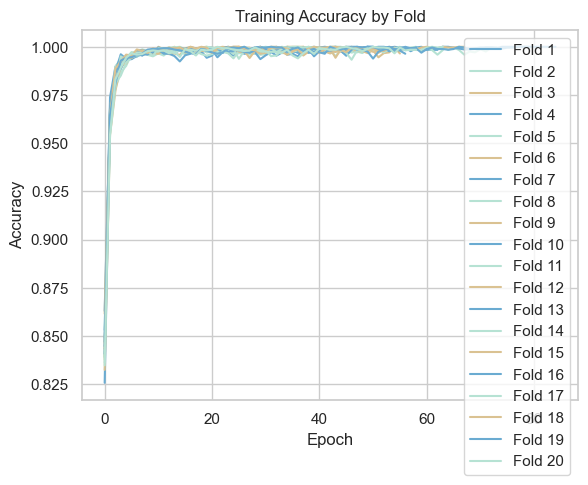

In [128]:
# Plot accuracy histories for all folds
for i, fold_accuracy in enumerate(total_training_acc):
    plt.plot(fold_accuracy, label=f'Fold {i+1}')

plt.title('Training Accuracy by Fold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [129]:
# running time including analysis
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 344.74257588386536 seconds
